Notebook for two-view reconstruction with inertial data.

This code is written upon vo_benchmark.ipynb.

Author: Jongwon Lee

Date: May 7th, 2024

In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

import vo, vio
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Provide settings

In [2]:
# When matching (max threshold for ratio test)
matching_threshold = 0.1 # I recommend 0.1 for KITTI and 0.5 for EuRoC

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

### Read data

Run these cells for KITTI

In [3]:
# RUN THIS CELL FOR KITTI
kitti_base_path = '/home/jlee/Downloads'
kitti_date = '2011_09_26'
kitti_drive = '0022'

# Read KITTI data
dataset_info = utils.read_data_kitti('/home/jlee/Downloads', '2011_09_26', '0022')

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

T_inC_ofB = dataset_info['cam0_extrinsics']

sigma_acc_wn = 1e-4  # accelerometer white noise sigma
sigma_gyr_wn = 1e-6  # gyroscope white noise sigma
sigma_acc_rw = 1e-5  # accelerometer random walk sigma
sigma_gyr_rw = 1e-7  # gyroscope random walk sigma

dt = 0.1

In [4]:
def imu_collate(data):
    w_x = np.stack([d['w_x'] for d in data])
    w_y = np.stack([d['w_y'] for d in data])
    w_z = np.stack([d['w_z'] for d in data])

    a_x = np.stack([d['a_x'] for d in data])
    a_y = np.stack([d['a_y'] for d in data])
    a_z = np.stack([d['a_z'] for d in data])

    acc_meas = np.vstack([a_x, a_y, a_z]).T
    gyr_meas = np.vstack([w_x, w_y, w_z]).T
    
    return acc_meas, gyr_meas

def groundtruth_collate(data):
    q_x = np.stack([d['groundtruth']['q_x'] for d in data])
    q_y = np.stack([d['groundtruth']['q_y'] for d in data])
    q_z = np.stack([d['groundtruth']['q_z'] for d in data])
    q_w = np.stack([d['groundtruth']['q_w'] for d in data])

    v_x = np.stack([d['groundtruth']['v_x'] for d in data])
    v_y = np.stack([d['groundtruth']['v_y'] for d in data])
    v_z = np.stack([d['groundtruth']['v_z'] for d in data])

    p_x = np.stack([d['groundtruth']['p_x'] for d in data])
    p_y = np.stack([d['groundtruth']['p_y'] for d in data])
    p_z = np.stack([d['groundtruth']['p_z'] for d in data])

    R_inW_ofB = R.from_quat(np.vstack([q_x, q_y, q_z, q_w]).T)
    v_inW_ofB = np.vstack([v_x, v_y, v_z]).T
    p_inW_ofB = np.vstack([p_x, p_y, p_z]).T
    
    return R_inW_ofB, v_inW_ofB, p_inW_ofB

acc_meas, gyr_meas = imu_collate(visual_inertial_data)
R_inW_ofB, v_inW_ofB, p_inW_ofB = groundtruth_collate(visual_inertial_data)

b_a = np.zeros(3)[:,np.newaxis].T
b_w = np.zeros(3)[:,np.newaxis].T

Run these cells for EuRoC

In [5]:
# RUN THIS CELL FOR MAV

euroc_base_path = '/home/jlee/Downloads'
euroc_sequence = 'V1_01_easy'

# MAV video folder
mav_video_folder = Path(euroc_base_path, euroc_sequence, 'mav0/')

# Read MAV data
dataset_info = utils.read_data_mav(mav_video_folder)
print("Read dataset with keys: {}".format(sorted(list(dataset_info.keys()))))

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

sigma_acc_wn = dataset_info['imu_accelerometer_noise_density']
sigma_gyr_wn = dataset_info['imu_gyroscope_noise_density']
sigma_acc_rw = dataset_info['imu_accelerometer_noise_density']
sigma_gyr_rw = dataset_info['imu_gyroscope_random_walk']

dt = 1/200

T_inB_ofC = dataset_info['cam0_extrinsics']
T_inC_ofB = np.block([[T_inB_ofC[:3,:3].T, (-T_inB_ofC[:3,:3].T @ T_inB_ofC[:3,-1])[:,np.newaxis]], [np.zeros(3), 1]])

Read dataset with keys: ['cam0_K', 'cam0_distortion', 'cam0_extrinsics', 'imu_accelerometer_noise_density', 'imu_accelerometer_random_walk', 'imu_extrinsics', 'imu_gyroscope_noise_density', 'imu_gyroscope_random_walk', 'visual_inertial_data']


In [6]:
def imu_collate(data):
    w_x = np.stack([d['w_x'] for d in data])
    w_y = np.stack([d['w_y'] for d in data])
    w_z = np.stack([d['w_z'] for d in data])

    a_x = np.stack([d['a_x'] for d in data])
    a_y = np.stack([d['a_y'] for d in data])
    a_z = np.stack([d['a_z'] for d in data])

    acc_meas = np.vstack([a_x, a_y, a_z]).T
    gyr_meas = np.vstack([w_x, w_y, w_z]).T
    
    return acc_meas, gyr_meas

def groundtruth_collate(data):
    q_x = np.stack([d['groundtruth']['q_x'] for d in data])
    q_y = np.stack([d['groundtruth']['q_y'] for d in data])
    q_z = np.stack([d['groundtruth']['q_z'] for d in data])
    q_w = np.stack([d['groundtruth']['q_w'] for d in data])

    v_x = np.stack([d['groundtruth']['v_x'] for d in data])
    v_y = np.stack([d['groundtruth']['v_y'] for d in data])
    v_z = np.stack([d['groundtruth']['v_z'] for d in data])

    p_x = np.stack([d['groundtruth']['p_x'] for d in data])
    p_y = np.stack([d['groundtruth']['p_y'] for d in data])
    p_z = np.stack([d['groundtruth']['p_z'] for d in data])

    b_w_x = np.stack([d['groundtruth']['b_w_x'] for d in data])
    b_w_y = np.stack([d['groundtruth']['b_w_y'] for d in data])
    b_w_z = np.stack([d['groundtruth']['b_w_z'] for d in data])

    b_a_x = np.stack([d['groundtruth']['b_a_x'] for d in data])
    b_a_y = np.stack([d['groundtruth']['b_a_y'] for d in data])
    b_a_z = np.stack([d['groundtruth']['b_a_z'] for d in data])

    R_inW_ofB = R.from_quat(np.vstack([q_x, q_y, q_z, q_w]).T)
    v_inW_ofB = np.vstack([v_x, v_y, v_z]).T
    p_inW_ofB = np.vstack([p_x, p_y, p_z]).T

    b_a = np.vstack([b_a_x, b_a_y, b_a_z]).T
    b_w = np.vstack([b_w_x, b_w_y, b_w_z]).T
    
    return R_inW_ofB, v_inW_ofB, p_inW_ofB, b_a, b_w

acc_meas, gyr_meas = imu_collate(dataset_info['visual_inertial_data'])
R_inR_ofB, v_inR_ofB, p_inR_ofB, b_a, b_w = groundtruth_collate(dataset_info['visual_inertial_data'])

In [7]:
# As EuRoC's ground-truth (MoCap) is not aligned with gravity (i.e., in world frame), we identify the orientation of MoCap frame in world frame
gravity = np.array([0., 0., -9.81])

g_inB = - np.mean(acc_meas[:10], axis=0)
g_inW = gravity

def align_vectors(g_inB, g_inW):
    # Normalize input vectors
    g_inB_unit = g_inB / np.linalg.norm(g_inB)
    g_inW_unit = g_inW / np.linalg.norm(g_inW)

    # Compute the axis of rotation
    v = np.cross(g_inB_unit, g_inW_unit)

    # Compute the angle of rotation
    cos_theta = np.dot(g_inB_unit, g_inW_unit)
    sin_theta = np.linalg.norm(v)
    theta = np.arctan2(sin_theta, cos_theta)

    v /= np.linalg.norm(v)
    
    # Compute the rotation matrix
    Rot = R.from_rotvec(theta*v)
    return Rot

# Compute rotation matrix
R_inW_ofB = align_vectors(g_inB, g_inW)
print("Rotation Matrix:\n", R_inW_ofB.as_matrix())

R_inW_ofB.apply(g_inB)

Rotation Matrix:
 [[-0.38045925 -0.0219894  -0.92453622]
 [-0.0219894   0.99964973 -0.01472698]
 [ 0.92453622  0.01472698 -0.38080952]]


array([-3.78169718e-16,  2.77555756e-17, -9.76648914e+00])

In [8]:
R_inW_ofR = R_inW_ofB * R_inR_ofB[:10].mean().inv()
R_inW_ofB = R_inW_ofR * R_inR_ofB
v_inW_ofB = R_inW_ofR.apply(v_inR_ofB)
p_inW_ofB = R_inW_ofR.apply(p_inR_ofB)

### Create random generator

In [9]:
rng = utils.create_rng(None)

seeding RNG with 2315374215


### Create image keypoint feature extractor

In [10]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [11]:
chosen_index = 2000
advance = 50

# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+advance)

# Create two views
views = [
    vio.create_view_data(utils.read_image(visual_inertial_data[first_frame_idx]['image_file']),
                         first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vio.create_view_data(utils.read_image(visual_inertial_data[second_frame_idx]['image_file']),
                         second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

# Perform two-view reconstruction
R_inC_ofB = T_inC_ofB[:3,:3]
p_inC_ofB = T_inC_ofB[:3,-1]

R_inC_ofW = R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T
p_inC_ofW = - R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx] + p_inC_ofB
tracks = vio.vo_2view(views, matching_threshold, cam0_K, R_inC_ofW, p_inC_ofW, rng, use_opencv=False)

found 42 good matches
found 42 inliers



REPROJECTION ERRORS
 Image  0 (   42 points) : (mean, std, max, min) = (  0.11,   0.08,   0.34,   0.00)
 Image (raw reprojection)  0 (   42 points) : (mean, std, max, min) = (  0.12,   0.07,   0.33,   0.00)
 Image  1 (   42 points) : (mean, std, max, min) = (  0.11,   0.08,   0.34,   0.00)
 Image (raw reprojection)  1 (   42 points) : (mean, std, max, min) = (  0.13,   0.08,   0.33,   0.00)


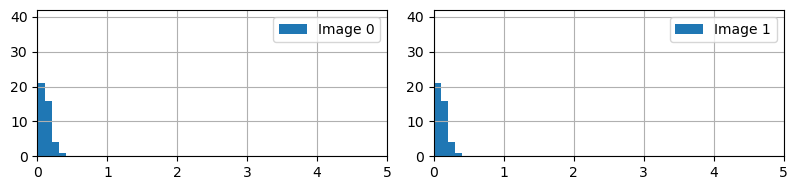

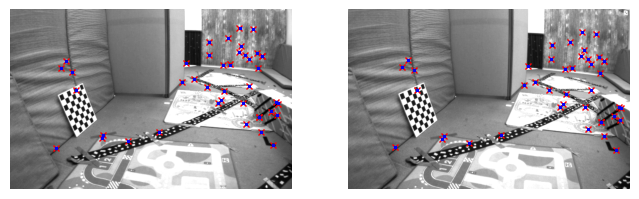

In [12]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

Get post-optimization solution

Run below to keep the initial views and tracks

In [13]:
views_ini = views.copy()
tracks_ini = tracks.copy()

Run two-view reconstruction with inertial data

In [14]:
T_inB0_ofW = np.block([[R_inW_ofB[first_frame_idx].as_matrix().T, - R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC0_ofW = T_inC_ofB @ T_inB0_ofW

T_inB1_ofW = np.block([[R_inW_ofB[second_frame_idx].as_matrix().T, - R_inW_ofB[second_frame_idx].as_matrix().T @ p_inW_ofB[second_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC1_ofW = T_inC_ofB @ T_inB1_ofW

T_inC0_ofW = None   # comment this out when you'd like to use ground truth as initial guess
T_inC1_ofW = None   # comment this out when you'd like to use ground truth as initial guess

views, tracks, initial_values, results = vio.vio_nonlinear_optimize(views_ini, tracks_ini, acc_meas[first_frame_idx:second_frame_idx], gyr_meas[first_frame_idx:second_frame_idx], 
                                                                    cam0_K, T_inC_ofB, max_reprojection_err,
                                                                    sigma_acc_wn, sigma_gyr_wn, sigma_acc_rw, sigma_gyr_rw, dt,
                                                                    np.mean(b_a, axis=0), np.mean(b_a, axis=0), np.mean(b_w, axis=0), np.mean(b_w, axis=0),
                                                                    v_inW_ofB[first_frame_idx], v_inW_ofB[second_frame_idx],
                                                                    T_inC0_ofW, T_inC1_ofW)

[2024-05-07 10:50:50.430] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 17970513.885/0.000/524902.062, rel reduction: 0.97079
[2024-05-07 10:50:50.435] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 524902.049/0.000/27492.494, rel reduction: 0.94762
[2024-05-07 10:50:50.441] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 27492.494/0.000/3120.543, rel reduction: 0.88649
[2024-05-07 10:50:50.446] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 3120.543/0.000/2255.854, rel reduction: 0.27710
[2024-05-07 10:50:50.452] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 2255.854/0.000/5605.545, rel reduction: -1.48489
[2024-05-07 10:50:50.457] [info] LM<sym::Optimize> [iter    5] lambda: 5.000e-04, error prev/linear/new: 2255.854/0.000/1038.814, rel reduction: 0.53950
[2024-05-07 10:50:50.462] [info] LM<sym::Optimize> [iter    6] lambda: 

Evaluate change in position between frames

In [15]:
# Symforce - Initial values
R_inW_ofC0_ini = results.initial_values['T_inC0_ofW'].R.to_rotation_matrix().T
p_inW_ofC0_ini = - R_inW_ofC0_ini @ results.initial_values['T_inC0_ofW'].t

R_inW_ofB0_ini = R_inW_ofC0_ini @ R_inC_ofB
p_inW_ofB0_ini = R_inW_ofC0_ini @ p_inC_ofB + p_inW_ofC0_ini

R_inW_ofC1_ini = results.initial_values['T_inC1_ofW'].R.to_rotation_matrix().T
p_inW_ofC1_ini = - R_inW_ofC1_ini @ results.initial_values['T_inC1_ofW'].t

R_inW_ofB1_ini = R_inW_ofC1_ini @ R_inC_ofB
p_inW_ofB1_ini = R_inW_ofC1_ini @ p_inC_ofB + p_inW_ofC1_ini

# Symforce - Optimized values
R_inW_ofC0_sf = results.optimized_values['T_inC0_ofW'].R.to_rotation_matrix().T
p_inW_ofC0_sf = - R_inW_ofC0_sf @ results.optimized_values['T_inC0_ofW'].t

R_inW_ofB0_sf = R_inW_ofC0_sf @ R_inC_ofB
p_inW_ofB0_sf = R_inW_ofC0_sf @ p_inC_ofB + p_inW_ofC0_sf

R_inW_ofC1_sf = results.optimized_values['T_inC1_ofW'].R.to_rotation_matrix().T
p_inW_ofC1_sf = - R_inW_ofC1_sf @ results.optimized_values['T_inC1_ofW'].t

R_inW_ofB1_sf = R_inW_ofC1_sf @ R_inC_ofB
p_inW_ofB1_sf = R_inW_ofC1_sf @ p_inC_ofB + p_inW_ofC1_sf

# ground truth
R_inW_ofB0_gt = R_inW_ofB[first_frame_idx].as_matrix()
p_inW_ofB0_gt = p_inW_ofB[first_frame_idx]
v_inW_ofB0_gt = v_inW_ofB[first_frame_idx]

R_inW_ofB1_gt = R_inW_ofB[second_frame_idx].as_matrix()
p_inW_ofB1_gt = p_inW_ofB[second_frame_idx]
v_inW_ofB1_gt = v_inW_ofB[second_frame_idx]

Error evaluation on optimized results

In [16]:
p_inW_ofB0toB1_ini = p_inW_ofB1_ini - p_inW_ofB0_ini
R_inB1_ofB0_ini = R_inW_ofB1_ini.T @ R_inW_ofB0_ini

p_inW_ofB0toB1_sf = p_inW_ofB1_sf - p_inW_ofB0_sf
R_inB1_ofB0_sf = R_inW_ofB1_sf.T @ R_inW_ofB0_sf

v_inW_ofB0toB1_gt = v_inW_ofB1_gt - v_inW_ofB0_gt
p_inW_ofB0toB1_gt = p_inW_ofB1_gt - p_inW_ofB0_gt
R_inB1_ofB0_gt = R_inW_ofB1_gt.T @ R_inW_ofB0_gt

dR_err_ini = R.from_matrix(R_inB1_ofB0_ini.T @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
dR_err_sf = R.from_matrix(R_inB1_ofB0_sf.T @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
print(f'dR: {dR_err_ini} (init.) --> {dR_err_sf} (optm.) [deg] (xyz)')

dp_err_ini = p_inW_ofB0toB1_ini - p_inW_ofB0toB1_gt
dp_err_sf = p_inW_ofB0toB1_sf - p_inW_ofB0toB1_gt
print(f'dp: {np.linalg.norm(dp_err_ini):.2f} (init.) --> {np.linalg.norm(dp_err_sf):.2f} (optm.) [m]')

dR: [ 0.18839705 -0.10054016  0.03086031] (init.) --> [ 0.39248517 -0.20538353  0.04583258] (optm.) [deg] (xyz)
dp: 0.95 (init.) --> 0.02 (optm.) [m]


(Optional) Error evaluation on preintegrated results

In [17]:
gravity = results.initial_values['gravity']
dt_01 = results.initial_values['dt_01']
dR_01 = results.initial_values['dR_01']
dv_01 = results.initial_values['dv_01']
dp_01 = results.initial_values['dp_01']

dR_err_pi = R.from_matrix(dR_01 @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
print(f'dR_preintegrated: {dR_err_pi} [deg] (xyz)')

v_inW_ofB0toB1_pi = R_inW_ofB0_gt @ dv_01 + gravity * dt_01
dv_err_pi = v_inW_ofB0toB1_pi - v_inW_ofB0toB1_gt

print(f'dv_preintegrated: {np.linalg.norm(v_inW_ofB0toB1_pi):.2f} [m/s] (abs err: {np.linalg.norm(dv_err_pi):.2f} [m/s], rel err: {np.linalg.norm(dv_err_pi)/np.linalg.norm(v_inW_ofB0toB1_gt)*100:.2f} [%])')

p_inW_ofB0toB1_pi = R_inW_ofB0_gt @ dp_01 + v_inW_ofB0_gt * dt_01 + 0.5 * gravity * dt_01 ** 2
dp_err_pi = p_inW_ofB0toB1_pi - p_inW_ofB0toB1_gt

print(f'dp_preintegrated: {np.linalg.norm(p_inW_ofB0toB1_pi):.2f} [m] (abs err: {np.linalg.norm(dp_err_pi):.2f} [m], rel err: {np.linalg.norm(dp_err_pi)/np.linalg.norm(p_inW_ofB0toB1_gt)*100:.2f} [%])')


dR_preintegrated: [-0.01827594 -0.16462037  0.05110297] [deg] (xyz)
dv_preintegrated: 0.10 [m/s] (abs err: 0.10 [m/s], rel err: 79.49 [%])
dp_preintegrated: 0.04 [m] (abs err: 0.01 [m], rel err: 23.64 [%])



REPROJECTION ERRORS
 Image  0 (   22 points) : (mean, std, max, min) = (  0.08,   0.08,   0.34,   0.00)
 Image (raw reprojection)  0 (   22 points) : (mean, std, max, min) = (  0.08,   0.07,   0.33,   0.00)
 Image  1 (   22 points) : (mean, std, max, min) = (  0.08,   0.08,   0.34,   0.00)
 Image (raw reprojection)  1 (   22 points) : (mean, std, max, min) = (  0.09,   0.08,   0.33,   0.00)


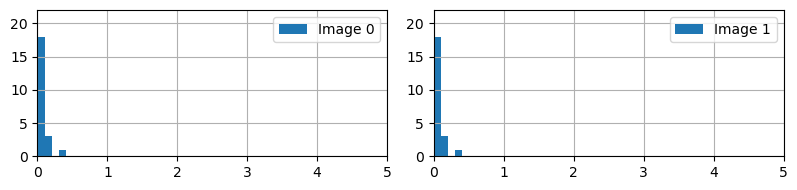

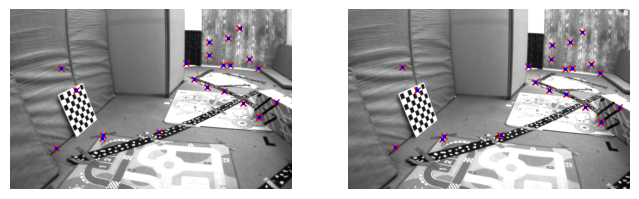

In [18]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

### Compute APE - example
Note, because we only have 2 views we don't have sufficient data to actually do an alignment.

In [19]:
ape_results = pose_metrics.compute_ape(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    temporary_folder / Path('traj1.txt'),
    temporary_folder / Path('traj2.txt'),
    temporary_folder / Path('results.zip'),
    temporary_folder / Path('results/'),
    align='none', verbose=False, print_results=True,
)

KeyError: 'R_inB_ofA'

### Compute pose error (with my alignment) example
Basically, we do a coordinate transform so both trajectories start at 0 pose and identity rotation. Then we calculate the error for each time-step. In our case, we probably should just care about the final error elements (which specifies errors between first and last frame).

In [ ]:
pose_results = pose_metrics.compute_pose_error(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    align='posescale', print_results=True,
)